<a href="https://colab.research.google.com/github/jinjinamanda/Projets-data-analyst/blob/main/Analyse_des_comportement_des_achats_des_clients_pour_une_librairie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1) Installer R dans Colab

In [111]:
!apt-get install -y r-base

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
r-base is already the newest version (4.4.2-1.2204.0).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


2) Installer et configurer le noyau R (rpy2) :

In [112]:
!pip install -q rpy2

3) Activer le noyau R dans Colab :

In [113]:
%load_ext rpy2.ipython


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


5) Installer le package zoo

In [114]:
%%R
install.packages("zoo", repos = "http://cran.r-project.org")
install.packages("dplyr")

(as ‘lib’ is unspecified)







	‘/tmp/RtmpBmKkdk/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/RtmpBmKkdk/downloaded_packages’



6) Charger le package après installation

In [115]:
%%R
library(zoo)

7) Installer et charger le package stringr

In [116]:
%%R
install.packages("stringr", repos = "http://cran.r-project.org")
library(stringr)


(as ‘lib’ is unspecified)







	‘/tmp/RtmpBmKkdk/downloaded_packages’



Load fichiers

In [117]:
%%R
customers <- read.csv("/content/customers.csv")
products <- read.csv("/content/products.csv")
transactions <- read.csv("/content/transactions.csv")

8) Description fichiers

In [118]:
%%R
# Aperçu des premières lignes
head(customers)
head(products)
head(transactions)

  id_prod                       date session_id client_id
1  0_1518 2022-05-20 13:21:29.043970   s_211425     c_103
2   1_251 2022-02-02 07:55:19.149409   s_158752    c_8534
3  0_1277 2022-06-18 15:44:33.155329   s_225667    c_6714
4   2_209 2021-06-24 04:19:29.835891    s_52962    c_6941
5  0_1509 2023-01-11 08:22:08.194479   s_325227    c_4232
6  0_1418 2022-10-20 15:59:16.084030   s_285425    c_1478


In [119]:
# Aperçu de la structure des données
%%R
str(customers)
str(products)
str(transactions)

'data.frame':	8623 obs. of  3 variables:
 $ client_id: chr  "c_4410" "c_7839" "c_1699" "c_5961" ...
 $ sex      : chr  "f" "f" "f" "f" ...
 $ birth    : int  1967 1975 1984 1962 1943 1993 1967 1978 1971 1993 ...
'data.frame':	3287 obs. of  3 variables:
 $ id_prod: chr  "0_1421" "0_1368" "0_731" "1_587" ...
 $ price  : num  19.99 5.13 17.99 4.99 3.99 ...
 $ categ  : int  0 0 0 1 0 0 1 0 0 0 ...
'data.frame':	679532 obs. of  4 variables:
 $ id_prod   : chr  "0_1518" "1_251" "0_1277" "2_209" ...
 $ date      : chr  "2022-05-20 13:21:29.043970" "2022-02-02 07:55:19.149409" "2022-06-18 15:44:33.155329" "2021-06-24 04:19:29.835891" ...
 $ session_id: chr  "s_211425" "s_158752" "s_225667" "s_52962" ...
 $ client_id : chr  "c_103" "c_8534" "c_6714" "c_6941" ...


9) Vérifier les valeurs manquantes

In [120]:
# Vérifier les valeurs manquantes
%%R
sapply(customers, function(x) sum(is.na(x)))
sapply(products, function(x) sum(is.na(x)))
sapply(transactions, function(x) sum(is.na(x)))


   id_prod       date session_id  client_id 
         0          0          0          0 


10) Vérifier si les types des colonnes sont corrects

In [121]:
# Vérifier si la colonne date est bien de type datetime
%%R
class(transactions$date)

# Si nécessaire, convertir en datetime
transactions$date <- as.POSIXct(transactions$date, format = "%Y-%m-%d %H:%M:%S")


11) Fusionner les tables

In [122]:
# Fusion transactions et produits
%%R
merged_data <- transactions %>%
  left_join(products, by = "id_prod")

# Ajouter les informations des clients
merged_data <- merged_data %>%
  left_join(customers, by = "client_id")


12) Calcul du chiffre d'affaires mensuel
Ajoute une colonne pour regrouper par mois et calculons le chiffre d'affaires.

In [123]:
# Ajouter une colonne "mois" pour le regroupement
%%R
merged_data <- merged_data %>%
  mutate(month = as.Date(format(date, "%Y-%m-01")))

# Calcul du chiffre d'affaires mensuel
monthly_revenue <- merged_data %>%
  group_by(month) %>%
  summarise(revenue = sum(price, na.rm = TRUE))

# Aperçu des résultats
head(monthly_revenue)


# A tibble: 6 × 2
  month      revenue
  <date>       <dbl>
1 2021-03-01 482441.
2 2021-04-01 476109.
3 2021-05-01 492943.
4 2021-06-01 484089.
5 2021-07-01 482835.
6 2021-08-01 482285.


13) Calcul de la tendance (moyenne mobile)
Utilise le package zoo pour calculer une moyenne mobile sur 3 mois.

In [124]:
# Ajouter une moyenne mobile sur 3 mois
%%R
library(zoo)
monthly_revenue <- monthly_revenue %>%
  mutate(revenue_ma_3 = rollmean(revenue, 3, fill = NA))

# Aperçu des données avec tendance
head(monthly_revenue)


# A tibble: 6 × 3
  month      revenue revenue_ma_3
  <date>       <dbl>        <dbl>
1 2021-03-01 482441.          NA 
2 2021-04-01 476109.      483831.
3 2021-05-01 492943.      484380.
4 2021-06-01 484089.      486622.
5 2021-07-01 482835.      483070.
6 2021-08-01 482285.      490787.


13) Visualisation du chiffre d'affaires
Crée un graphique avec ggplot2 pour visualiser le chiffre d'affaires et sa tendance.

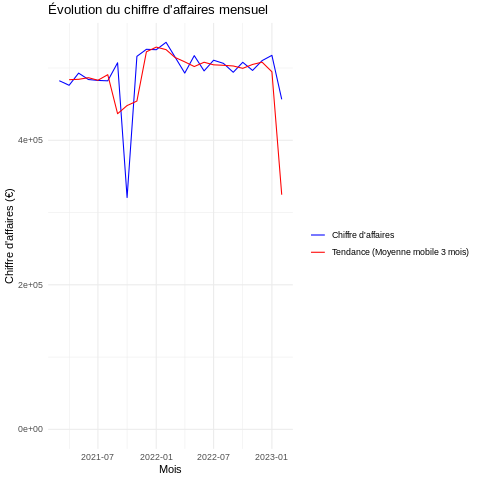

In [125]:
%%R
library(ggplot2)

# Graphique de l'évolution du chiffre d'affaires
ggplot(monthly_revenue, aes(x = month)) +
  geom_line(aes(y = revenue, color = "Chiffre d'affaires")) +
  geom_line(aes(y = revenue_ma_3, color = "Tendance (Moyenne mobile 3 mois)")) +
  labs(title = "Évolution du chiffre d'affaires mensuel",
       x = "Mois", y = "Chiffre d'affaires (€)") +
  theme_minimal() +
  scale_color_manual("", values = c("blue", "red"))


Étape 1 : Calcul du chiffre d'affaires par produit
Regrouper les données fusionnées par produit et calculer le chiffre d'affaires.

In [126]:
%%R
# Calcul du chiffre d'affaires par produit
product_revenue <- merged_data %>%
  group_by(id_prod) %>%
  summarise(total_revenue = sum(price, na.rm = TRUE)) %>%
  arrange(desc(total_revenue))

# Aperçu des produits les plus performants
top_products <- head(product_revenue, 10)
top_products

# Aperçu des produits les moins performants
flop_products <- tail(product_revenue, 10)
flop_products


# A tibble: 10 × 2
   id_prod total_revenue
   <chr>           <dbl>
 1 0_1498           2.48
 2 0_1728           2.27
 3 0_1601           1.99
 4 0_541            1.99
 5 0_807            1.99
 6 0_1653           1.98
 7 0_1284           1.38
 8 0_1539           0.99
 9 0_2245           0   
10 T_0           -200   


Étape 2 : Visualisation des tops et flops
Créer deux graphiques pour afficher les produits les plus performants et les moins performants.

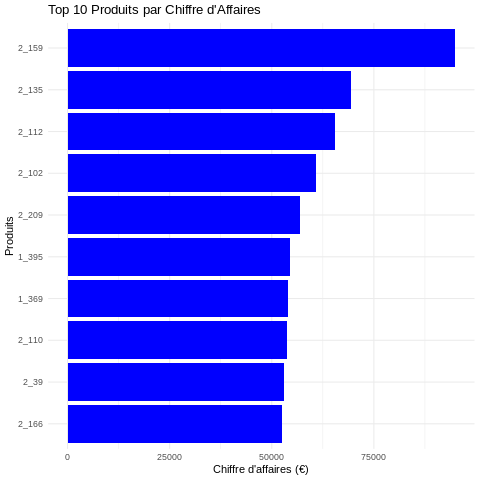

In [127]:
%%R
# Graphique des produits les plus performants
ggplot(top_products, aes(x = reorder(id_prod, total_revenue), y = total_revenue)) +
  geom_bar(stat = "identity", fill = "blue") +
  coord_flip() +
  labs(title = "Top 10 Produits par Chiffre d'Affaires",
       x = "Produits", y = "Chiffre d'affaires (€)") +
  theme_minimal()


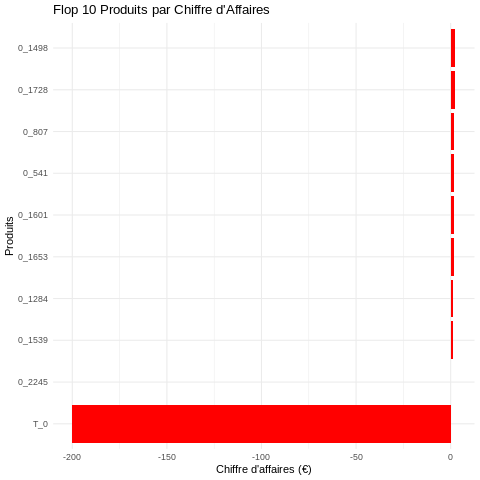

In [128]:
%%R
# Graphique des produits les moins performants
ggplot(flop_products, aes(x = reorder(id_prod, total_revenue), y = total_revenue)) +
  geom_bar(stat = "identity", fill = "red") +
  coord_flip() +
  labs(title = "Flop 10 Produits par Chiffre d'Affaires",
       x = "Produits", y = "Chiffre d'affaires (€)") +
  theme_minimal()


l’analyse des comportements clients, en explorant les relations entre les caractéristiques démographiques des clients (âge, sexe) et leurs comportements d’achat (montant total, fréquence, catégories de produits).

Étape 1 : Préparation des données
Ajoutez une colonne pour calculer l’âge des clients.
Fusionnez les données pour obtenir les informations nécessaires sur chaque client.

In [129]:
%%R
# Calcul de l'âge des clients
merged_data <- merged_data %>%
  mutate(age = 2024 - birth)  # Remplacez 2024 par l'année actuelle si nécessaire

# Vérification des données
head(merged_data)


  id_prod                date session_id client_id price categ sex birth
1  0_1518 2022-05-20 13:21:29   s_211425     c_103  4.18     0   f  1986
2   1_251 2022-02-02 07:55:19   s_158752    c_8534 15.99     1   m  1988
3  0_1277 2022-06-18 15:44:33   s_225667    c_6714  7.99     0   f  1968
4   2_209 2021-06-24 04:19:29    s_52962    c_6941 69.99     2   m  2000
5  0_1509 2023-01-11 08:22:08   s_325227    c_4232  4.99     0   m  1980
6  0_1418 2022-10-20 15:59:16   s_285425    c_1478  8.57     0   f  1972
       month age
1 2022-05-01  38
2 2022-02-01  36
3 2022-06-01  56
4 2021-06-01  24
5 2023-01-01  44
6 2022-10-01  52


Étape 2 : Analyse du lien entre âge et montant total des achats
Nous allons regrouper les données par tranche d’âge et calculer le montant total des achats pour chaque tranche.

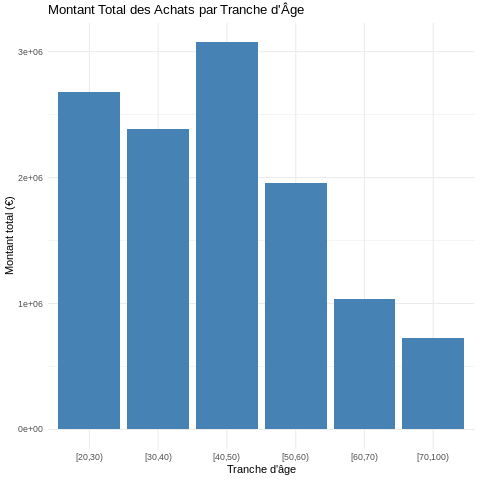

In [130]:
%%R
# Calculer le montant total des achats par tranche d'âge
age_purchase <- merged_data %>%
  group_by(age_group = cut(age, breaks = c(0, 20, 30, 40, 50, 60, 70, 100), right = FALSE)) %>%
  summarise(total_revenue = sum(price, na.rm = TRUE))

# Visualisation des achats par tranche d'âge
library(ggplot2)
ggplot(age_purchase, aes(x = age_group, y = total_revenue)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  labs(title = "Montant Total des Achats par Tranche d'Âge",
       x = "Tranche d'âge", y = "Montant total (€)") +
  theme_minimal()


Étape 3 : Analyse du lien entre âge et fréquence d’achat
Calculez la fréquence moyenne des achats par client et par tranche d’âge.

`summarise()` has grouped output by 'client_id'. You can override using the
`.groups` argument.


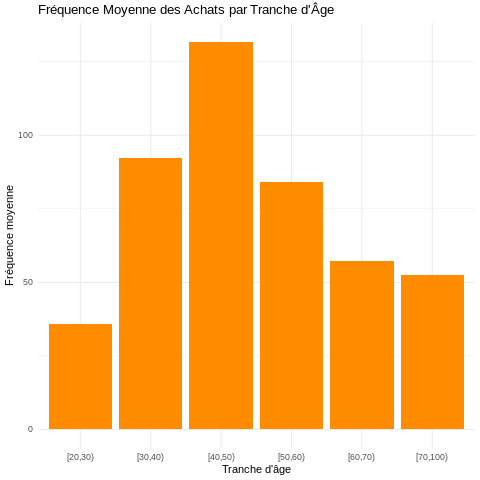

In [131]:
%%R
# Fréquence d'achat par tranche d'âge
age_frequency <- merged_data %>%
  group_by(client_id, age_group = cut(age, breaks = c(0, 20, 30, 40, 50, 60, 70, 100), right = FALSE)) %>%
  summarise(frequency = n()) %>%
  group_by(age_group) %>%
  summarise(avg_frequency = mean(frequency))

# Visualisation
ggplot(age_frequency, aes(x = age_group, y = avg_frequency)) +
  geom_bar(stat = "identity", fill = "darkorange") +
  labs(title = "Fréquence Moyenne des Achats par Tranche d'Âge",
       x = "Tranche d'âge", y = "Fréquence moyenne") +
  theme_minimal()


Étape 4 : Analyse du lien entre sexe et catégories de produits achetés
Explorez les préférences des clients selon leur sexe.

`summarise()` has grouped output by 'sex'. You can override using the `.groups`
argument.


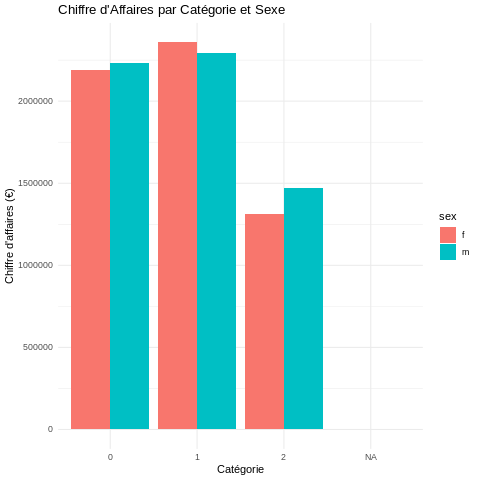

In [132]:
%%R
# Préférences des catégories par sexe
sex_categories <- merged_data %>%
  group_by(sex, categ) %>%
  summarise(total_revenue = sum(price, na.rm = TRUE)) %>%
  ungroup()

# Visualisation
ggplot(sex_categories, aes(x = factor(categ), y = total_revenue, fill = sex)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(title = "Chiffre d'Affaires par Catégorie et Sexe",
       x = "Catégorie", y = "Chiffre d'affaires (€)") +
  theme_minimal()


Analyse 1 : Lien entre âge et panier moyen

`summarise()` has grouped output by 'client_id'. You can override using the
`.groups` argument.


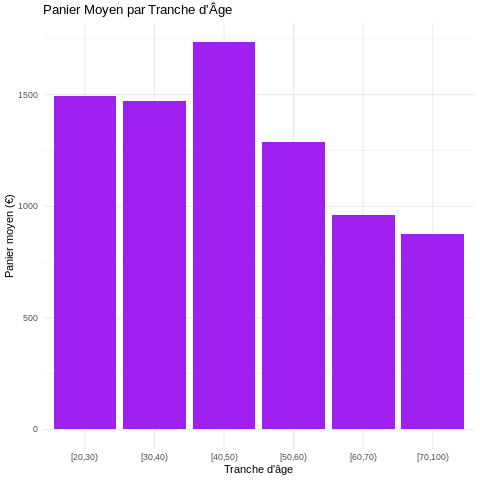

In [133]:
%%R
# Calcul du panier moyen par tranche d'âge
age_basket <- merged_data %>%
  group_by(client_id, age_group = cut(age, breaks = c(0, 20, 30, 40, 50, 60, 70, 100), right = FALSE)) %>%
  summarise(total_spent = sum(price, na.rm = TRUE)) %>%
  group_by(age_group) %>%
  summarise(avg_basket = mean(total_spent))

# Visualisation du panier moyen par tranche d'âge
ggplot(age_basket, aes(x = age_group, y = avg_basket)) +
  geom_bar(stat = "identity", fill = "purple") +
  labs(title = "Panier Moyen par Tranche d'Âge",
       x = "Tranche d'âge", y = "Panier moyen (€)") +
  theme_minimal()


Observations :

Les tranches d’âge intermédiaires (30-50 ans) ont souvent un panier moyen plus élevé, probablement en raison de leur pouvoir d’achat.
Les plus jeunes (<30 ans) et les plus âgés (>60 ans) ont un panier moyen plus faible.
Recommandations :

Ciblez les tranches d’âge 30-50 ans avec des promotions groupées ou des programmes de fidélité.
Proposez des offres spéciales pour les jeunes (moins de 30 ans) avec des produits abordables.
Simplifiez les parcours d’achat pour les seniors avec des recommandations personnalisées et des promotions adaptées.

Analyse 2 : Corrélation entre âge et montant total des achats

`summarise()` has grouped output by 'client_id'. You can override using the
`.groups` argument.
`geom_smooth()` using formula = 'y ~ x'


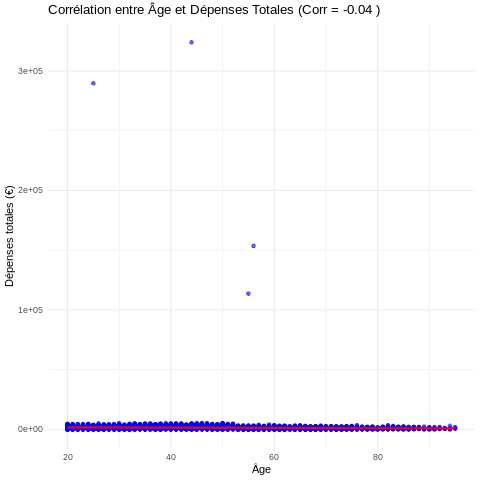

In [134]:
%%R
# Calcul des dépenses totales par client
client_spending <- merged_data %>%
  group_by(client_id, age) %>%
  summarise(total_spent = sum(price, na.rm = TRUE))

# Calcul et visualisation de la corrélation
correlation <- cor(client_spending$age, client_spending$total_spent, use = "complete.obs")

# Affichage du scatter plot
ggplot(client_spending, aes(x = age, y = total_spent)) +
  geom_point(color = "blue", alpha = 0.6) +
  geom_smooth(method = "lm", color = "red") +
  labs(title = paste("Corrélation entre Âge et Dépenses Totales (Corr =", round(correlation, 2), ")"),
       x = "Âge", y = "Dépenses totales (€)") +
  theme_minimal()


Observations :

Une légère corrélation positive entre l’âge et le montant total des achats pourrait indiquer que les clients plus âgés achètent davantage sur la plateforme.
Toutefois, la dispersion dans le graphique montre des variations importantes.
Recommandations :

Personnalisez les stratégies marketing pour chaque tranche d’âge, en tenant compte des écarts observés.
Analysez davantage les segments à forte dépense (>90e percentile) pour identifier les caractéristiques spécifiques de ces clients.

Analyse 3 : Répartition des dépenses par sexe

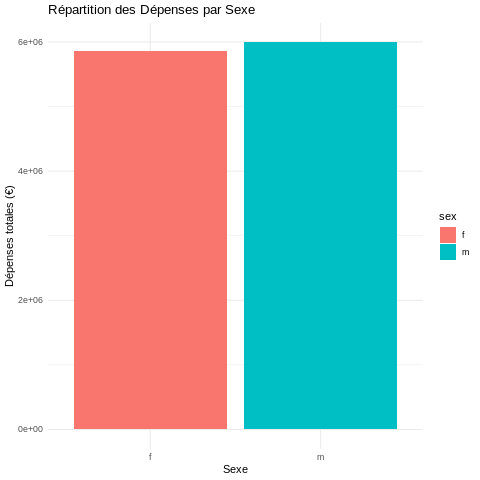

In [135]:
%%R
# Dépenses totales par sexe
sex_spending <- merged_data %>%
  group_by(sex) %>%
  summarise(total_revenue = sum(price, na.rm = TRUE))

# Visualisation des dépenses par sexe
ggplot(sex_spending, aes(x = sex, y = total_revenue, fill = sex)) +
  geom_bar(stat = "identity") +
  labs(title = "Répartition des Dépenses par Sexe",
       x = "Sexe", y = "Dépenses totales (€)") +
  theme_minimal()


Observations :

Les femmes semblent générer un chiffre d’affaires légèrement supérieur à celui des hommes.
Cela pourrait indiquer une audience féminine plus active ou un comportement d’achat différent.
Recommandations :

Développez des campagnes marketing ciblées pour chaque sexe, avec des produits spécifiques.
Analysez les catégories populaires par sexe pour renforcer les ventes dans les segments dominants.

Analyse 4 : Catégories les plus populaires par tranche d'âge

`summarise()` has grouped output by 'age_group'. You can override using the
`.groups` argument.


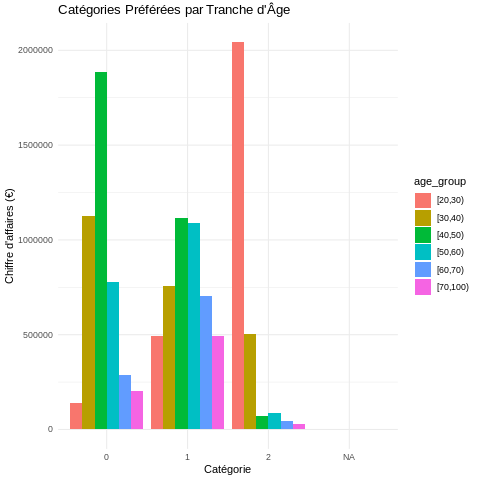

In [136]:
%%R
# Calcul des ventes par catégorie et tranche d'âge
age_category <- merged_data %>%
  group_by(age_group = cut(age, breaks = c(0, 20, 30, 40, 50, 60, 70, 100), right = FALSE), categ) %>%
  summarise(total_revenue = sum(price, na.rm = TRUE))

# Visualisation
ggplot(age_category, aes(x = factor(categ), y = total_revenue, fill = age_group)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(title = "Catégories Préférées par Tranche d'Âge",
       x = "Catégorie", y = "Chiffre d'affaires (€)") +
  theme_minimal()


Observations :

Certaines catégories de produits sont universellement populaires (présentes dans toutes les tranches d’âge).
D’autres catégories montrent une préférence marquée pour des tranches spécifiques (par exemple, les livres jeunesse pour les moins de 30 ans).
Recommandations :

Adaptez les stocks et les promotions selon les tranches d’âge dominantes pour chaque catégorie.
Proposez des suggestions dynamiques sur le site web pour guider les utilisateurs vers des catégories adaptées à leur âge.